# Dynamics for Aircraft Mission Performance

So, what we've demonstrated so far is great for problems where we care about the nitty-gritty of what's happening - we are directly simulating all flight dynamics modes.

For the quadcopter doing a flip, this is a good thing! The vehicle's dynamics have characteristic times that are on the same timescale as the maneuvers of interest, so we should just go ahead and simulate everything.

However, this is overly complex for most aircraft design problems. Most missions of interest are on the order of hours long, while most aircraft flight dynamics modes are on the order of seconds.

We can therefore make some simplifying assumptions:

* The vehicle's short-period modes are negligible, and all modes that don't affect the vehicle energy management (i.e., performance) can be discarded. (On an airplane with classical flight dynamics modes, this would mean that we would ignore all modes other than the phugoid mode.)
* This implies that the angular rates $p$, $q$, and $r$ are zero.
* All lateral modes can be ignored, as we assume that $\beta, \phi, p, r=0$.
* Because the short-period longitudinal mode is negligible and $q=0$, we assume $\theta$ can be prescribed - so $\theta$ is now a control variable, not a state variable.
* Our remaining state variables are $x_e, z_e, u, w$. We can re-parameterize this as $x_e, z_e, V, \gamma$ (where $V$ is the airspeed and $\gamma$ is the flight path angle) to reduce coupling.

Here, we can show what that looks like in practice.

## Optimal Gliding Problem

Let's say you're my Ph.D. advisor, John Hansman, and you're flying over central Massachusetts in your Cessna 152. All of a sudden, you hear your engine start to sputter - oh no.

In [1]:
thrust = 0

Let's determine:

1. Can he make it back to the airport?
2. What's the most energy-optimal trajectory to fly?

### Performance Estimation

To start, let's roughly define a vehicle geometry here, which we'll then use to estimate vehicle performance. (Both Geometry and Aerodynamics are covered in later tutorial sections.)

#### Geometry Reconstruction

Geometry is roughly given by this three-view:

![threeview](./assets/cessna150.gif)

Which we can represent as:

In [2]:
import aerosandbox as asb
import aerosandbox.numpy as np
from aerosandbox.tools import units as u

from cessna152 import airplane  # See cessna152.py for details.

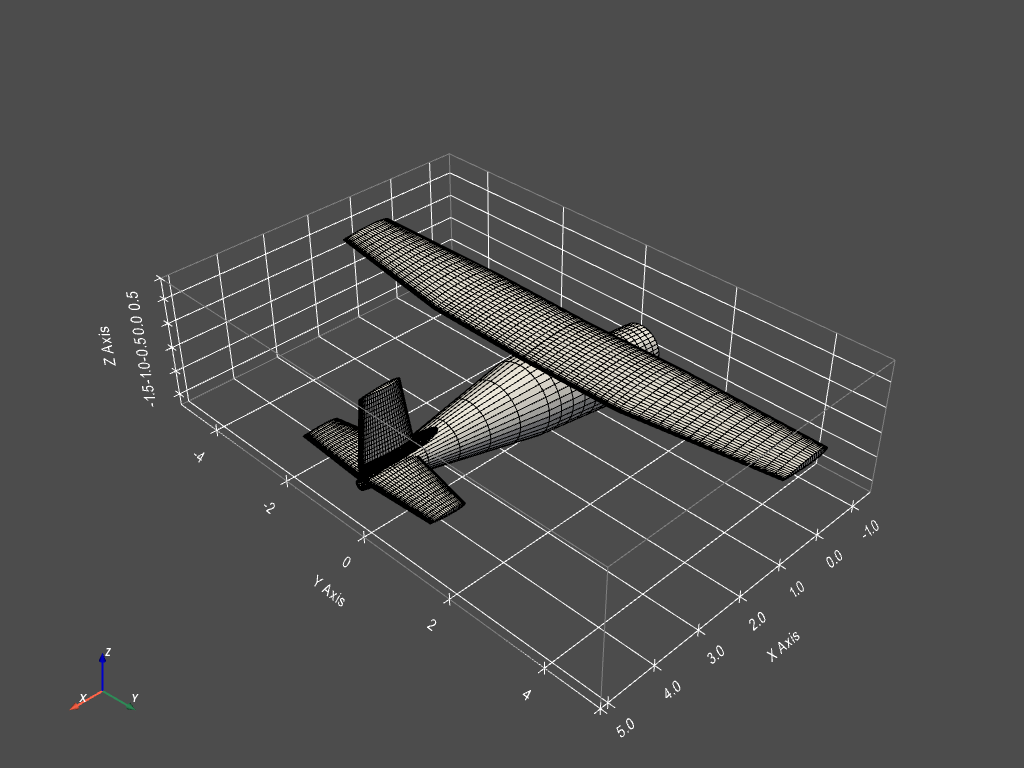

In [3]:
# NBVAL_SKIP

mesh = airplane.draw(show=False)
import pyvista as pv

p = pv.Plotter()
p.add_mesh(mesh, show_edges=True)
p.add_axes()
p.add_bounding_box()
p.renderer.show_grid()
p.show(jupyter_backend="static")

By the way, if the visualization above doesn't run on your computer due to a missing visualization dependency, it's possible you may have installed only a minimal (headless) version of AeroSandbox, rather than the full version. As a reminder:

* `pip install aerosandbox` -> minimal (headless) version
* `pip install aerosandbox[full]` -> full version, with visualization dependencies

#### Aerodynamic Performance Estimation

We can then use our geometry to estimate polars:

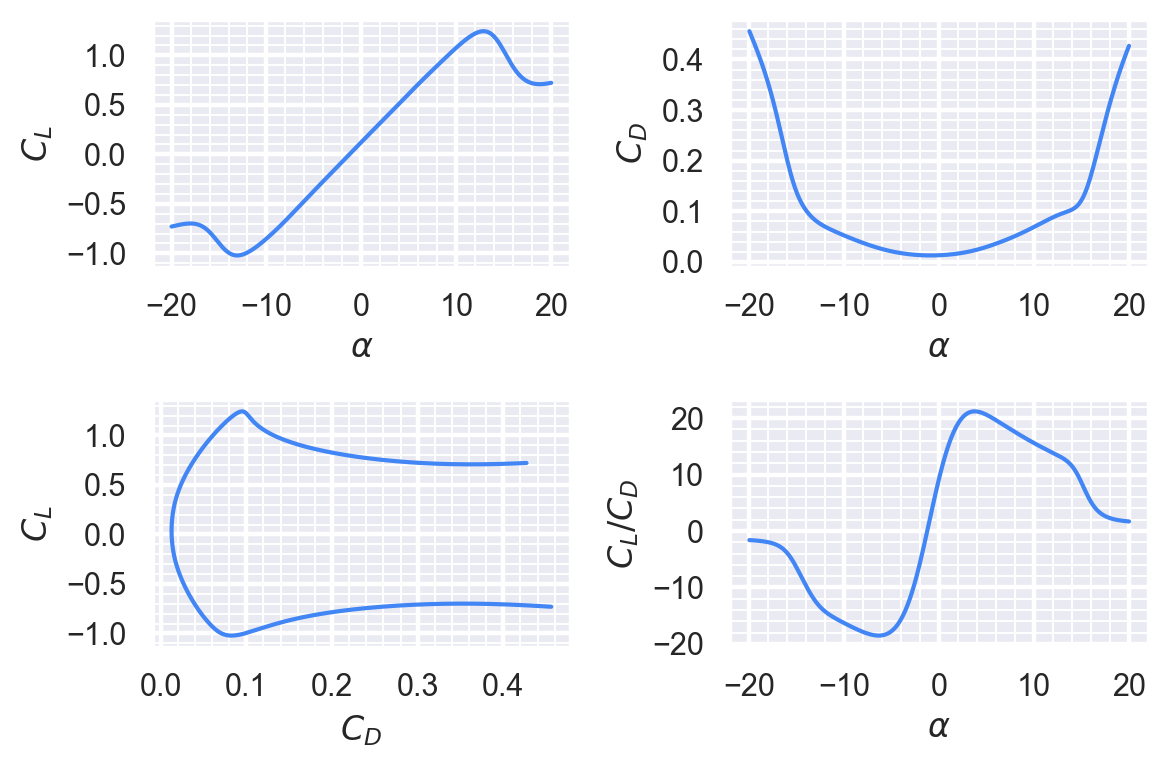

In [4]:
alpha = np.linspace(-20, 20, 500)
aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=107 * u.knot,
        alpha=alpha,
    )
).run()

import matplotlib.pyplot as plt;
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(2, 2)
plt.sca(ax[0, 0])
plt.plot(alpha, aero["CL"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_L$")
p.set_ticks(10, 2, 0.5, 0.1)

plt.sca(ax[0, 1])
plt.plot(alpha, aero["CD"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_D$")
p.set_ticks(10, 2, 0.1, 0.02)

plt.sca(ax[1, 0])
plt.plot(aero["CD"], aero["CL"])
plt.xlabel(r"$C_D$")
plt.ylabel(r"$C_L$")
p.set_ticks(0.1, 0.02, 0.5, 0.1)

plt.sca(ax[1, 1])
plt.plot(alpha, aero["CL"] / aero["CD"])
plt.xlabel(r"$\alpha$")
plt.ylabel(r"$C_L/C_D$")
p.set_ticks(10, 2, 10, 2)

p.show_plot()

### Aircraft Dynamics

Now, let's implement the dynamics for the airplane.

First, let's define some mass properties.

In [5]:
from aerosandbox.weights.mass_properties_of_shapes import mass_properties_from_radius_of_gyration

mass_props = mass_properties_from_radius_of_gyration(
    mass=1151.8 * u.lbm,
    radius_of_gyration_x=2,
    radius_of_gyration_y=3,
    radius_of_gyration_z=3,
)
mass_props.x_cg = 1


Now, we have all the pieces to implement our trajectory optimization problem.

In [6]:
### Initialize the problem
opti = asb.Opti()

### Define time. Note that the horizon length is unknown.
time_final_guess = 100
time = np.linspace(
    0,
    opti.variable(init_guess=time_final_guess, log_transform=True),
    250
)
N = np.length(time)

time_guess = np.linspace(0, time_final_guess, N)

### Create a dynamics instance
init_state = {
    "x_e"  : 0,
    "z_e"  : -1000,  # 1 km altitude
    "speed": 107 * u.knot,
    "gamma": 0,
}

dyn = asb.DynamicsPointMass2DSpeedGamma(
    mass_props=mass_props,
    x_e=opti.variable(init_state["speed"] * time_guess),
    z_e=opti.variable(np.linspace(init_state["z_e"], 0, N)),
    speed=opti.variable(init_guess=init_state["speed"], n_vars=N),
    gamma=opti.variable(init_guess=0, n_vars=N, lower_bound=-np.pi / 2, upper_bound=np.pi / 2),
    alpha=opti.variable(init_guess=5, n_vars=N, lower_bound=-5, upper_bound=15),
)
# Constrain the initial state
for k in dyn.state.keys():
    opti.subject_to(
        dyn.state[k][0] == init_state[k]
    )

### Add in forces
dyn.add_gravity_force(g=9.81)

aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=dyn.op_point
).run()

dyn.add_force(
    *aero["F_w"],
    axes="wind"
)

### Constrain the altitude to be above ground at all times
opti.subject_to(
    dyn.altitude > 0
)

### Finalize the problem
dyn.constrain_derivatives(opti, time)  # Apply the dynamics constraints created up to this point

opti.minimize(-dyn.x_e[-1])  # Go as far downrange as you can

### Solve it
sol = opti.solve()

### Substitute the optimization variables in the dynamics instance with their solved values (in-place)
dyn.substitute_solution(sol)

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     7972
Number of nonzeros in inequality constraint Jacobian.:     1250
Number of nonzeros in Lagrangian Hessian.............:     3001

Total number of variables............................:     1251
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:     1000
Total number of inequality constraints...............:     1250
        inequality constraints with only lower bounds:      750
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:      500

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 -

DynamicsPointMass2DSpeedGamma instance:
	State variables:
		     x_e: [    0.           139.06502534   258....
		     z_e: [-1.00000000e+03 -1.01624209e+03 -1.0...
		   speed: [55.04555556 49.82838126 41.91198378 ...
		   gamma: [-4.39692817e-23  2.44774167e-01  2.4...
	Control variables:
		   alpha: [ 2.33035625  1.92289673  1.53694263 ...
		    Fx_w: [-4.45050627e+02 -1.58138649e+03 -1.4...
		    Fz_w: [-3.70813164e+03 -1.38072314e+03  1.0...

Let's visualize the solution.

First, we can plot it in 3D:

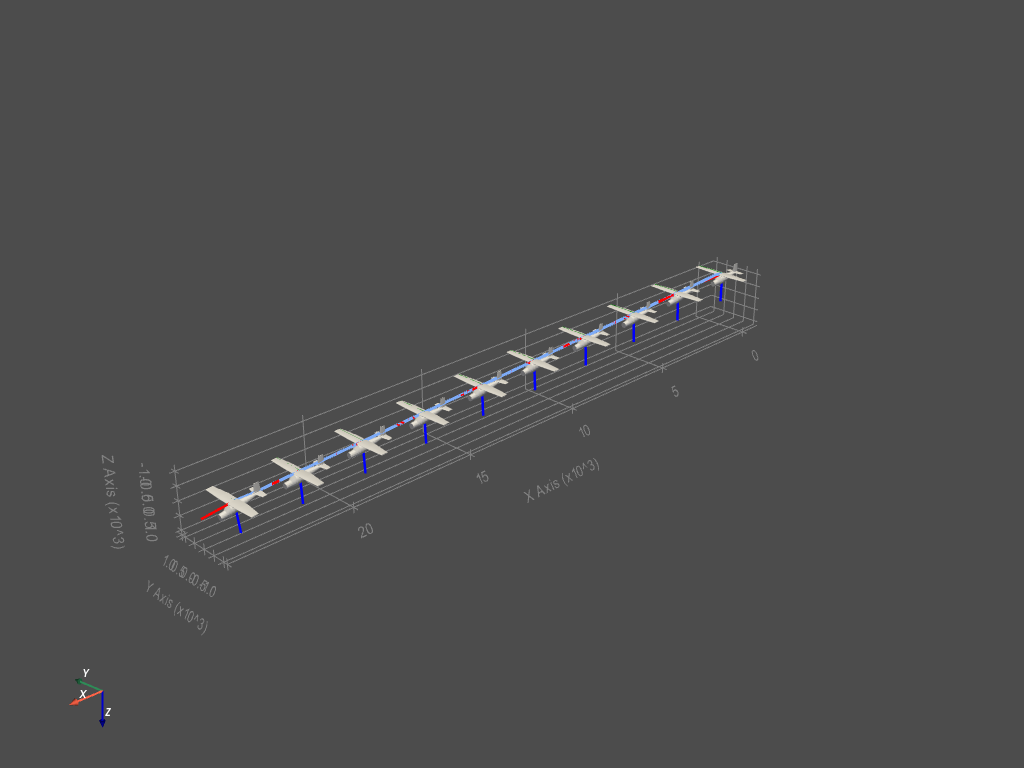

In [7]:
# NBVAL_SKIP

plotter = dyn.draw(
    vehicle_model=airplane,
    show=False
)
plotter.show(jupyter_backend="static")

Or, for a 2D-ified view:

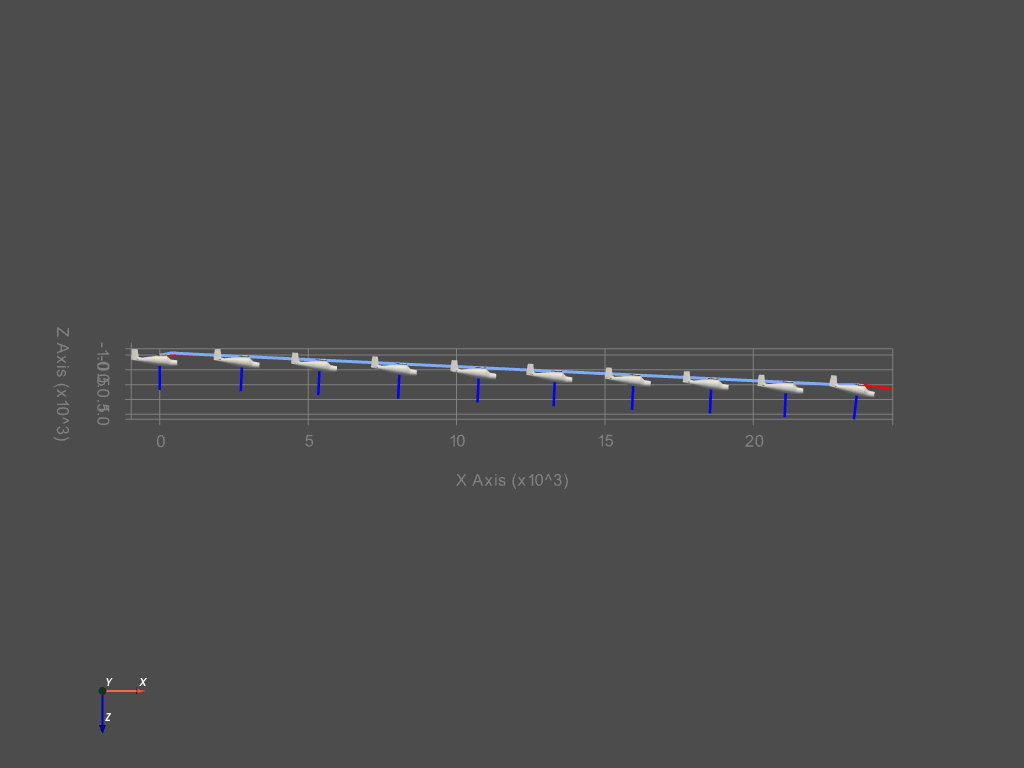

In [8]:
# NBVAL_SKIP

plotter = dyn.draw(
    vehicle_model=airplane,
    show=False
)
plotter.camera.enable_parallel_projection()
plotter.camera_position = 'xz'
plotter.camera.roll = 180
plotter.camera.azimuth = 180
plotter.show(jupyter_backend="static")

Enough pretty pictures - let's get quantitative and look more closely at some state variables:

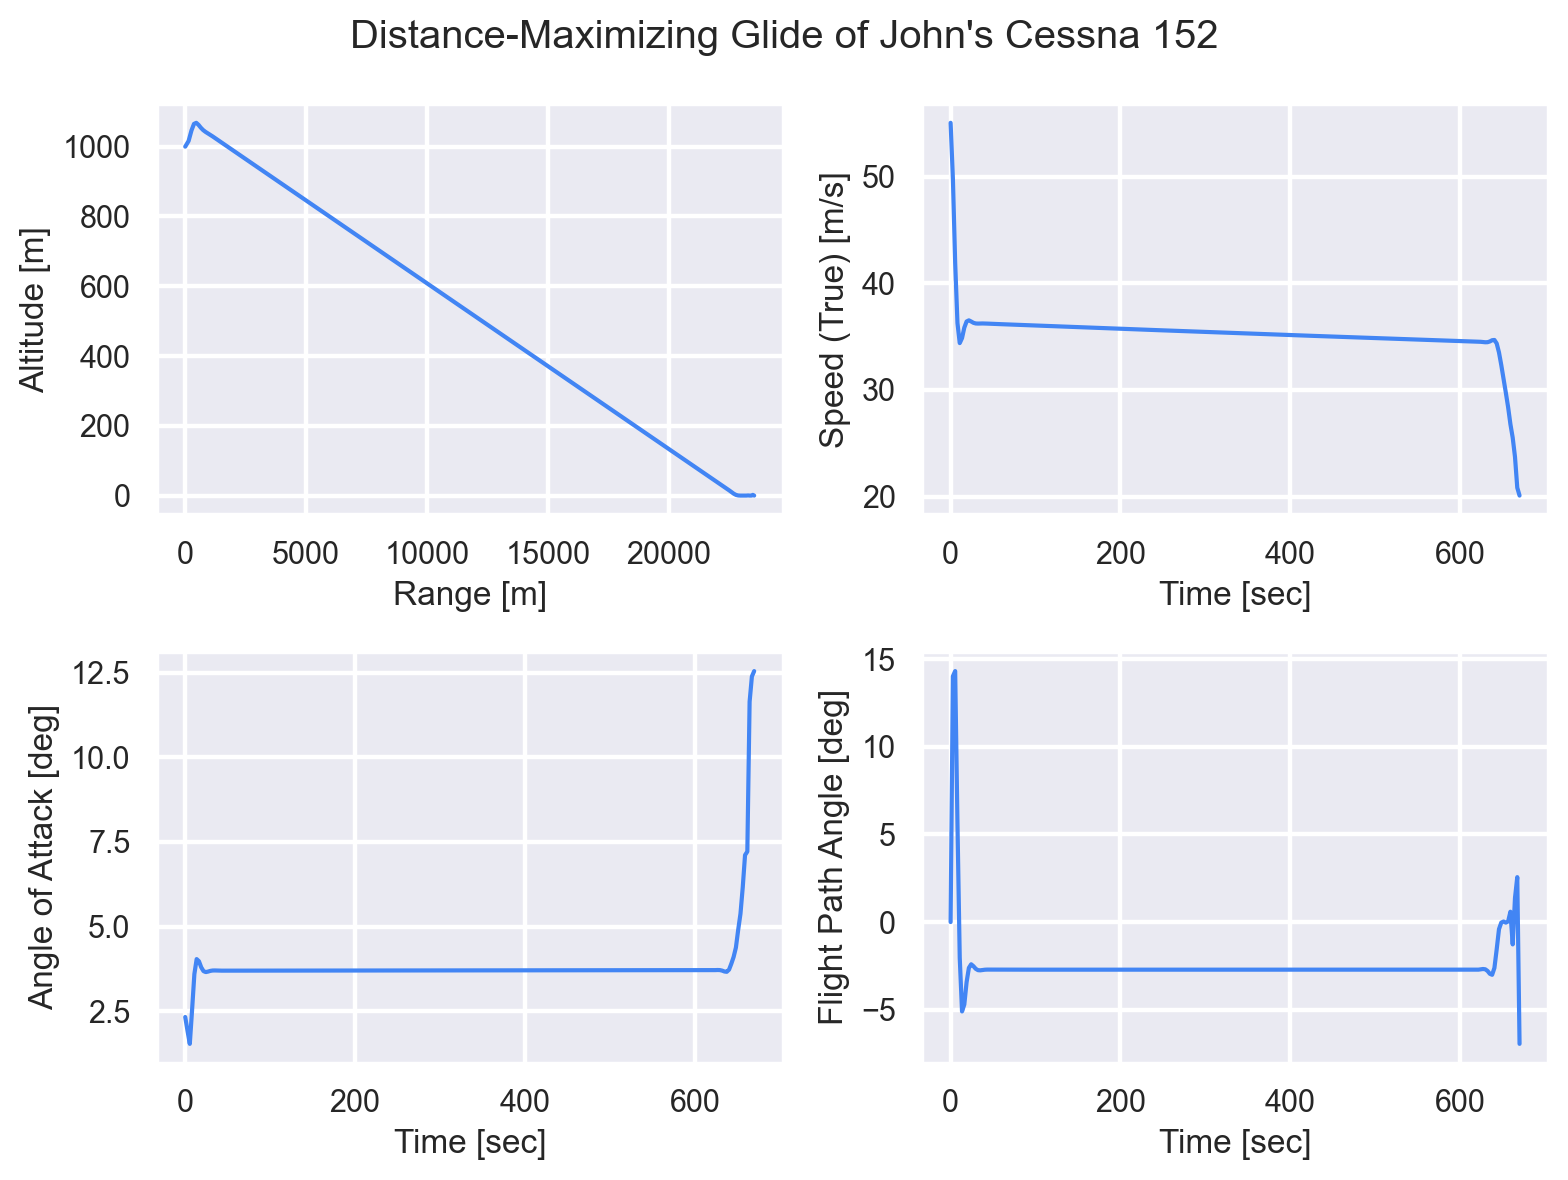

In [9]:
fig, ax = plt.subplots(2, 2, figsize=(8, 6))
plt.sca(ax[0, 0])
plt.plot(dyn.x_e, dyn.altitude)
plt.xlabel("Range [m]")
plt.ylabel("Altitude [m]")

plt.sca(ax[0, 1])
plt.plot(sol.value(time), dyn.speed)
plt.xlabel("Time [sec]")
plt.ylabel("Speed (True) [m/s]")

plt.sca(ax[1, 0])
plt.plot(sol.value(time), dyn.alpha)
plt.xlabel("Time [sec]")
plt.ylabel("Angle of Attack [deg]")

plt.sca(ax[1, 1])
plt.plot(sol.value(time), np.degrees(dyn.gamma))
plt.xlabel("Time [sec]")
plt.ylabel("Flight Path Angle [deg]")

p.show_plot("Distance-Maximizing Glide of John's Cessna 152")

Okay, so what's happening here? Let's make some observations about the solution that we've found:

* The pilot, John, should immediately pull back on the stick and enter a pitch-up trajectory. Cruise speed of 107 knots (55 m/s) is far faster than best-glide speed and simply burns off energy to drag. Executing this pitch-up maneuver will convert this excess kinetic energy into excess potential energy that can extend the glide.
* Once the pilot has reached the best-glide speed, they should trim to essentially maintain that speed. Note on the speed plot above that the speed slightly decreases during the glide - this is because the speed indicated here is *true* airspeed rather than *indicated* airspeed (air density is changing as we descend).
* At the end of the glide, we should put the airplane into ground effect and gradually pull back more and more on the stick (increasing alpha). This will dump speed and let us glide just a little further.

All in all, this study shows how we can maximize the glide range of an airplane using AeroSandbox dynamics engines.